In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import telegram
import pandahouse
from datetime import date
import io
from read_db.CH import Getch
import sys
import os

In [2]:
# Search anomaly function
# Use a three-sigma rule
def check_anomaly(df, metric, a=3, n=6):
    df['mean'] = df[metric].shift(1).rolling(n).mean().round(1)
    df['std'] = df[metric].shift(1).rolling(n).std().round(2)
    df['upper'] = df['mean'] + a * df['std'] 
    df['lower'] = df['mean'] - a * df['std'] 
    df['upper'] = df['upper'].rolling(n, center=True, min_periods=1).mean()
    df['lower'] = df['lower'].rolling(n, center=True, min_periods=1).mean()

    if df[metric].iloc[-1] < df['lower'].iloc[-1] or df[metric].iloc[-1] > df['upper'].iloc[-1]:
        is_alert = 1
    else:
        is_alert = 0
    
    return is_alert, df

In [9]:
def run_alerts(chat=None):
    chat_id = chat or 958349291
    bot = telegram.Bot(token=os.environ.get("report_bot_token"))

    # Connect to database
    connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
    }
    
    # Get the data, set interval to 15 minutes
    q = """SELECT toStartOfFifteenMinutes(time) as ts, 
    toDate(ts) as date,
    formatDateTime(ts, '%R') as hm,
    countIf(user_id, os='Android') AS sent_from_Android,
    countIf(user_id, os='iOS') AS sent_from_iOS
    FROM simulator_20220220.message_actions
    WHERE ts >=  today() - 1 and ts < toStartOfFifteenMinutes(now())
    GROUP BY ts, date, hm
    ORDER BY ts"""
    
    data = pandahouse.read_clickhouse(q, connection=connection)
    
    print(data.head(3))
    print()
    
    metrics_list = ['sent_from_Android', 'sent_from_iOS']
    for metric in metrics_list:
        plt.figure()
        print(metric)
        df = data[['ts', 'date', 'hm', metric]].copy()
        is_alert, df = check_anomaly(df, metric)
        
        if is_alert == 1 or True:
            msg = '''Messages {metric}: {current_val} ({last_val_diff:.2%})'''.format(metric=metric, 
                                                                                current_val=df[metric].iloc[-1],
                                                                               last_val_diff= 1-(df[metric].iloc[-1]/df[metric].iloc[-2]))
        
            sns.set(rc={'figure.figsize': (10, 6)})
            plt.tight_layout()
        
            ax = sns.lineplot(x=df['ts'], y=df[metric], label='messages')
            ax = sns.lineplot(x=df['ts'], y=df['upper'], label='upper')
            ax = sns.lineplot(x=df['ts'], y=df['lower'], label='lower')
        
            for ind, label in enumerate(ax.get_xticklabels()):
                if ind % 2 == 0:
                    label.set_visible(True)
                else:
                    label.set_visible(False)
        
            ax.set(xlabel='Time')
            ax.set(ylabel='Messages')

            ax.set_title(metric)
            ax.set(ylim=(0, None))
        
            # plot_object = io.BytesIO()
            # ax.figure.savefig(plot_object)
            # plot_object.seek(0)
            # plot_object.name = '{0}.png'.format(metric)
            # plt.close()

            # bot.sendMessage(chat_id=chat_id, text=msg)
            # bot.sendPhoto(chat_id=chat_id, photo=plot_object)
            
            print(msg)
            
    return

In [ ]:
try:
    run_alerts()
except Exception as e:
    print(e)

View message and plots:

                   ts       date     hm  sent_from_Android  sent_from_iOS
0 2022-04-10 00:00:00 2022-04-10  00:00                 40             36
1 2022-04-10 00:15:00 2022-04-10  00:15                 49             34
2 2022-04-10 00:30:00 2022-04-10  00:30                 56             29

sent_from_Android
Messages sent_from_Android: 104 (12.61%)
sent_from_iOS
Messages sent_from_iOS: 44 (38.03%)


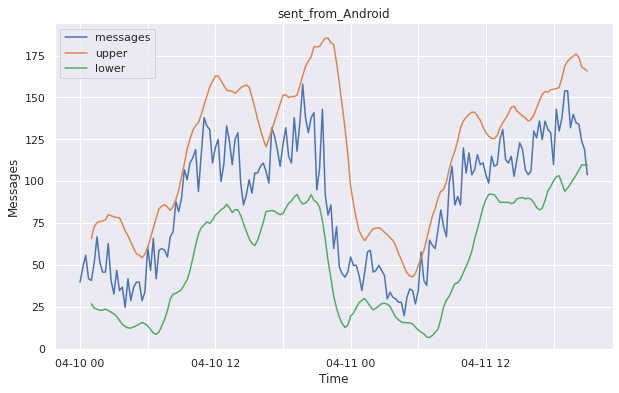

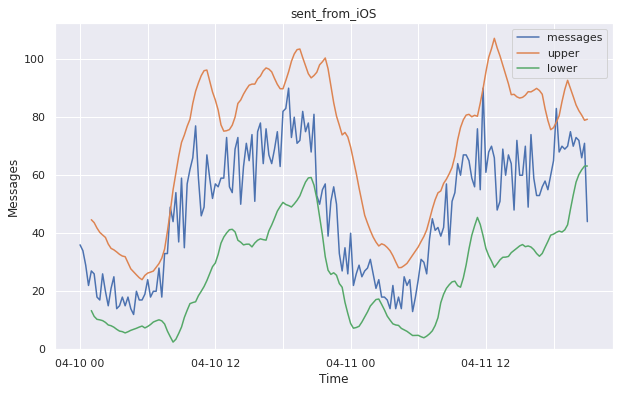

In [10]:
run_alerts()